In [3]:
import chaospy
import numpy as np

# 1. 不確かさを持つ確率変数 (θ) を定義
#    U(-1, 1) の一様分布
theta = chaospy.Uniform(-1, 1)

# 2. 多項式カオス展開 (PCE) の設定
p_order = 4  # 展開の次数
# θの分布に対応する直交多項式（ルジャンドル多項式）を生成
polynomials, norms = chaospy.generate_expansion(
    p_order, theta, retall=True
)
# print(norms)

# 3. 不確かさを含む関数 a(θ) を定義
#    【変更点】通常のPython関数として定義します
def a_func(theta_val):
    return -3 + 1.0 * theta_val

# 4. 求積法のためのノードと重みを生成
#    ガウス求積法を使用します
nodes, weights = chaospy.generate_quadrature(
    p_order + 1, theta, rule="gaussian"
)

# 5. 生成したノード上で関数 a(θ) の値を評価
evals = a_func(nodes[0])

# 6. a(θ) をPCEで近似（係数を計算）
#    【変更点】`fit_quadrature` にノード、重み、評価値を渡します
a_pce = chaospy.fit_quadrature(polynomials, nodes, weights, evals)


# 7. ガラーキン射影を用いて拡張行列 A を構築（この部分は変更なし）
Agpc = np.zeros((p_order + 1, p_order + 1))
for i in range(p_order + 1):
    for j in range(p_order + 1):
        # 分子: E[a(θ) * Φ_i * Φ_j]
        numerator = chaospy.E(a_pce * polynomials[i] * polynomials[j], theta)
        # 分母: E[Φ_i^2]
        denominator = norms[i]
        Agpc[i, j] = numerator / denominator

# --- 結果の出力 ---
print(f"PCEの次数: {p_order}")
print("\na(θ) のPCE近似:")
print(chaospy.around(a_pce, 4))
print("\n多項式カオス展開によって拡張された行列 A:")
print(np.around(Agpc, decimals=8))

PCEの次数: 4

a(θ) のPCE近似:
q0-3.0

多項式カオス展開によって拡張された行列 A:
[[-3.          0.33333333  0.         -0.         -0.        ]
 [ 1.         -3.          0.26666667  0.         -0.        ]
 [ 0.          1.         -3.          0.25714286  0.        ]
 [-0.          0.          1.         -3.          0.25396825]
 [-0.         -0.          0.          1.         -3.        ]]


<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
C:\Users\shun-\AppData\Local\Temp\ipykernel_15936\2243626596.py:13: SyntaxWarning: invalid escape sequence '\d'
  """
DEBUG:2025-08-02 16:00:16,495:jax._src.path:37: etils.epath was not found. Using pathlib for file I/O.


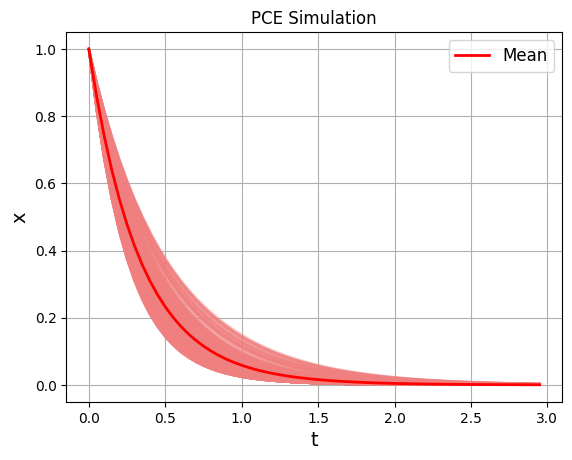

In [4]:
import numpy as np
import jax.numpy as jnp
from jax import jacfwd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from controller_Nash import PCEController
from scipy.linalg import solve_continuous_lyapunov as solve_lyapunov
from numpy.linalg import norm, inv
from scipy.integrate import solve_ivp
from scipy.special import eval_legendre

def solve_differential_equation(Agpc, x0, t_span, t_eval):
    """
    \dot{x} = Agpc @ x を解く関数
    """
    def model(t, x):
        return Agpc @ x
    solution = solve_ivp(model, t_span, x0, t_eval=t_eval)
    return solution

# --- パラメータと初期条件の設定 ---
# 初期値 [x1(0), x2(0)]
p_terms = p_order + 1
x0 = [0]*(p_terms)
x_o = [1]
nominal_indices = [0,p_terms]
for i, val in zip(nominal_indices, x_o):
    x0[i] = val

# 計算する時間範囲 (0秒から10秒まで)
time_span = (0, 3)

# 解を求める時間点 (0.1秒ごと)
evaluation_times = np.arange(time_span[0], time_span[1], 0.05)


# --- 微分方程式を解いて結果をプロット ---
# 関数を呼び出して解を計算
sol = solve_differential_equation(Agpc, x0, time_span, evaluation_times)

# MCであらゆるθに対してplotする
def calcurate_variance(data, index, p_terms):
    var = 0
    for i in range(1,p_terms):
        coeffs = data[(index-1)*p_terms+i]
        norm = 1/(2*i+1)
        var += norm*coeffs**2
    return var
def calcurate_legendre_polynomial(n, x):
    """Calculate the nth Legendre polynomial at point x."""
    return eval_legendre(n, x)

mean_x1 = sol.y[0]
var_x1 = calcurate_variance(sol.y, 1, p_terms) 

# t-xのグラフを描画
for i in range(500):
    theta = np.random.uniform(low=-1.0, high=1.0)
    # print(theta)
    x1 = 0
    for j in range(p_terms):
        coeffs_x1 = sol.y[(0)*p_terms+j]
        x1 += coeffs_x1 * calcurate_legendre_polynomial(j, theta)
    plt.plot(sol.t, x1, color = 'lightcoral', alpha=0.2)
# 平均軌道をプロット (濃い色、太い線)
# 平均を赤でプロット
plt.plot(sol.t, mean_x1, color='red', linewidth=2, label='Mean')
plt.title(f'PCE Simulation')
plt.xlabel('t', fontsize=14)
plt.ylabel('x', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


In [4]:
import numpy as np
import jax.numpy as jnp
from jax import jacfwd
import scipy.linalg as la
from scipy.special import legendre
from scipy.integrate import quad, solve_ivp
from numpy.polynomial.legendre import legvander
from scipy.linalg import solve_continuous_lyapunov as solve_lyapunov
from numpy.linalg import norm, inv
from scipy.integrate import solve_ivp

In [17]:
def legendre_inner_product(i, j, k):
    # ルジャンドル多項式の生成
    Pi, Pj, Pk = legendre(i), legendre(j), legendre(k)
    # 積分対象の関数
    integrand = lambda x: Pi(x) * Pj(x) * Pk(x) / 2
    # 区間 [a, b] で数値積分
    result, _ = quad(integrand, -1, 1)
    return result
p_terms = 5
Phi0 = np.zeros((p_terms, p_terms))
for i in range(p_terms):
    for j in range(p_terms):
            norm = 1 / (2 * i + 1)
            Phi0[i, j] = legendre_inner_product(i, 0, j) / norm
print("Phi0 =\n", np.around(Phi0, decimals=4))
Phi1 = np.zeros((p_terms, p_terms))
for i in range(p_terms):
    for j in range(p_terms):
            norm = 1 / (2 * i + 1)
            Phi1[i, j] = legendre_inner_product(i, 1, j) / norm
print("Phi1 =\n", np.around(Phi1, decimals=4))
# Phi2 = np.zeros((p_terms, p_terms))
# for i in range(p_terms):
#     for j in range(p_terms):
#             norm = 1 / (2 * i + 1)
#             Phi2[i, j] = legendre_inner_product(i, 2, j) / norm
# print("Phi2 =\n", np.around(Phi2, decimals=4))
# Phi3 = np.zeros((p_terms, p_terms))
# for i in range(p_terms):
#     for j in range(p_terms):
#             norm = 1 / (2 * i + 1)
#             Phi3[i, j] = legendre_inner_product(i, 3, j) / norm
# print("Phi3 =\n", np.around(Phi3, decimals=4))
# Phi4 = np.zeros((p_terms, p_terms))
# for i in range(p_terms):
#     for j in range(p_terms):
#             norm = 1 / (2 * i + 1)
#             Phi4[i, j] = legendre_inner_product(i, 4, j) / norm
# print("Phi4 =\n", np.around(Phi4, decimals=4))
Phi = -3 * Phi0  + 1 * Phi1
print("Phi =\n", np.around(Phi, decimals=4))

Phi0 =
 [[ 1.  0.  0.  0.  0.]
 [ 0.  1. -0.  0. -0.]
 [ 0. -0.  1. -0.  0.]
 [ 0.  0. -0.  1. -0.]
 [ 0. -0.  0. -0.  1.]]
Phi1 =
 [[ 0.      0.3333 -0.      0.     -0.    ]
 [ 1.      0.      0.4    -0.      0.    ]
 [-0.      0.6667 -0.      0.4286 -0.    ]
 [ 0.     -0.      0.6    -0.      0.4444]
 [-0.      0.     -0.      0.5714 -0.    ]]
Phi =
 [[-3.      0.3333 -0.      0.     -0.    ]
 [ 1.     -3.      0.4    -0.      0.    ]
 [-0.      0.6667 -3.      0.4286 -0.    ]
 [ 0.     -0.      0.6    -3.      0.4444]
 [-0.      0.     -0.      0.5714 -3.    ]]
